# Case study: Standard data augmentation 

In [1]:
import sys
import matplotlib 
import matplotlib.pyplot as plt
from pathlib import Path
import itertools

import numpy as np 
import pandas as pd
import seaborn as sns
import torch

sys.path.append('..')
from src.data import datasets
from src.data import transforms as data_transforms
from src.utils import common_utils
from src.utils import datamodels_utils as dm_utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_style('whitegrid')

## Setup

In [2]:
cmap = plt.get_cmap('tab10')
hist_kws = dict(element='step', lw=2, alpha=0.75, stat='count')
font_kws = dict(title_fs=17, label_fs=15, legend_fs=15, ticks_fs=14)

_metadata = pd.read_pickle('metadata/living17_val_metadata.df')
class_names = dict(zip(_metadata['class'], _metadata['class_name'].apply(lambda s: s[:10])))

dsets = {
    'val': datasets.Living17('val', data_transforms.LIVING17_TRANSFORMS['val']),
    'train': datasets.Living17('train', data_transforms.LIVING17_TRANSFORMS['val'])
}

dm_names = {
    'aug': r'With data augmentation ($\mathcal{A}_1$)',
    'no_aug': 'Without data augmentation ($\mathcal{A}_2$)'
}

dm_paths = {
    'aug': '../datamodels/living17_data-aug.pt',
    'no_aug': '../datamodels/living17_without-data-aug.pt'
}

labels = {
    'val': [[x] for x in pd.read_pickle('metadata/living17_val_metadata.df')['class'].tolist()],
    'train': [[x] for x in pd.read_pickle('metadata/living17_train_metadata.df')['class'].tolist()]
}

## Model accuracies
Accuracies of models trained with and without standard data augmentation (horizontal flips and random crops). These models are used to compute the datamodel matrices $\theta^{(1)}$ and $\theta^{(2)}$ corresponding to models trained with and without augmentation respectively.

<AxesSubplot:title={'center':'Model accuracies'}, xlabel='Accuracy', ylabel='Count'>

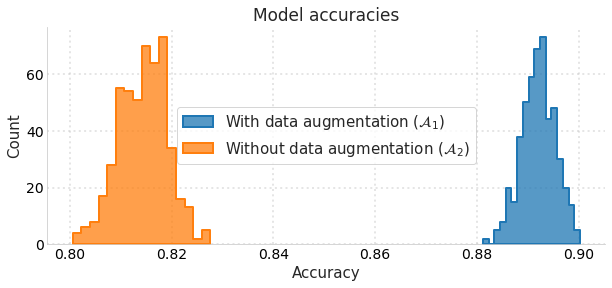

In [3]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
M = torch.load('metadata/living17_val_classification_profile.pkl')
for idx, (k, M_) in enumerate(M.items()):
    ax = sns.histplot(M_.mean(axis=1), ax=ax, label=dm_names[k], color=cmap(idx), **hist_kws)
common_utils.update_ax(ax, 'Model accuracies', 'Accuracy', 'Count', legend_loc='center', **font_kws)

## Datamodel sparsity
Compare distribution over (row-wise) fraction of non-zeros in datamodels matrices $\theta^{(1)}$ and $\theta^{(2)}$, which correspond to models trained with and without augmentation respectively.

[None, None, None, None]

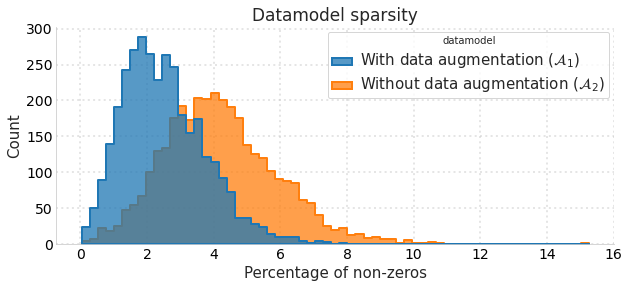

In [4]:
dfs = []
sp_map = {}

for key, pth in dm_paths.items():
    if not pth: continue
    dm = np.array(torch.load(pth)['weight']).T    
    df_ = pd.DataFrame()
    sp_map[key] = df_['sparsity'] = (np.abs(dm)>1e-6).mean(axis=1)*100 
    df_['datamodel'] = dm_names[key]
    dfs.append(df_)

df = pd.concat(dfs).reset_index()

fig, ax = plt.subplots(1,1,figsize=(10,4))
ax = sns.histplot(data=df, x='sparsity', hue='datamodel', **hist_kws)
common_utils.update_ax(ax, 'Datamodel sparsity', 'Percentage of non-zeros', 'Count', legend_loc=False, **font_kws)
plt.setp(ax.get_legend().get_texts(), fontsize=font_kws['legend_fs'])

## Cosine similarity between datamodels
Look at distribution over cosine similarity between datamodel vectors $\theta^{(1)}_x$ and $\theta^{(2)}_x$, which correspond to datamodel of example $x$ for models trained with and without augmentation respectively.

<AxesSubplot:title={'center':'Cosine similarity between datamodels $\\theta^{(1)}_x$ and $\\theta^{(2)}_x$'}, xlabel='Cosine Similarity', ylabel='Count'>

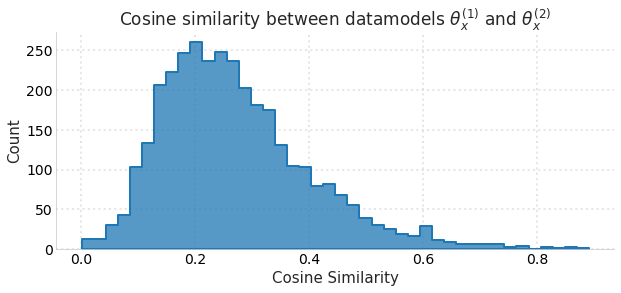

In [5]:
keys = list(itertools.combinations(dm_paths.keys(), 2))
cs_map = {} 

for k1, k2 in keys:
    if k1==k2: continue
    dm1 = torch.load(dm_paths[k1])['weight'].T.numpy()
    dm2 = torch.load(dm_paths[k2])['weight'].T.numpy()
    cs_map[(k1,k2)] = dm_utils.get_cosine_similarity(dm1, dm2)
    
fig, ax = plt.subplots(1,1,figsize=(10,4))
for idx, ((k1,k2), cs) in enumerate(cs_map.items()): 
    mean_cs = np.mean(cs)
    ax = sns.histplot(cs, color=cmap(idx), ax=ax, **hist_kws)
    
common_utils.update_ax(ax, 
                       r'Cosine similarity between datamodels $\theta^{(1)}_x$ and $\theta^{(2)}_x$', 
                       'Cosine Similarity', 'Count', legend_loc=False, **font_kws)

## Top-most datamodel influencers
Find top-most training examples that have the largest magnitude datmaodel weight in $\theta^{(1)}_x$ and $\theta^{(2)}_x$ for randomly sampled Living17 test image $x$.

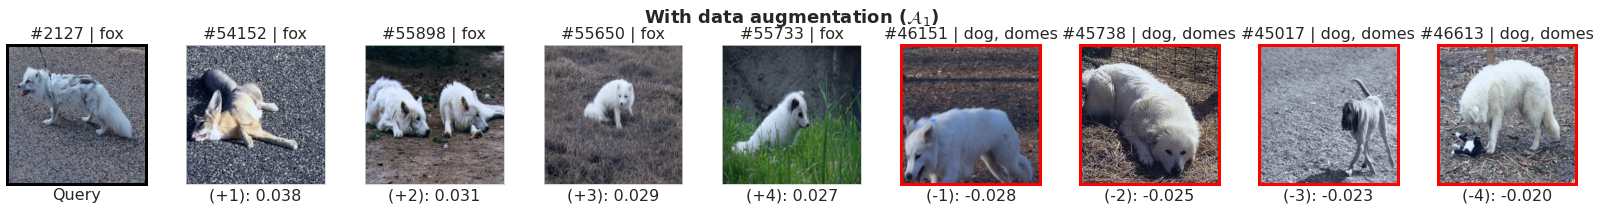

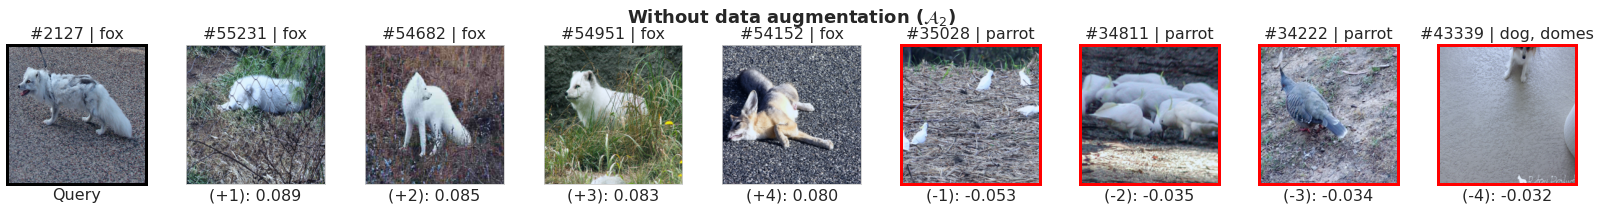

In [7]:
# visualize images with large magnitude datamodel weights  
inf_map = {}

for k, dm_path in dm_paths.items():
    dm = torch.load(dm_path)['weight'] 
    inf_map[k] = dm_utils.InfluenceVisualizer(dm, 'val', dsets, 
                                              label_indices=[0], 
                                              label_tuples=labels)
    
random_indices = np.random.randint(0, high=len(dsets['val']), size=1)
for k, inf in inf_map.items():
    fig, ax_grid = inf.plot_influencers(random_indices, 8, mode='both', 
                                        class_names=class_names)
    fig.suptitle(dm_names[k], y=1.1, fontsize=18, fontweight='bold')

## PCA on residual datamodel
Visualize PC components of residual datamodel matrix $\theta^{(1\setminus 2)}_x$. These PC components correspond to training directions that are more "important" for models trained with augmentation (algorithm $\mathcal{A}_1$) than for models trained without augmentation (algorithm $\mathcal{A}_2$)

Text(0.5, 0.95, 'Principal components of residual datamodel $\\theta^{(1-2)}$')

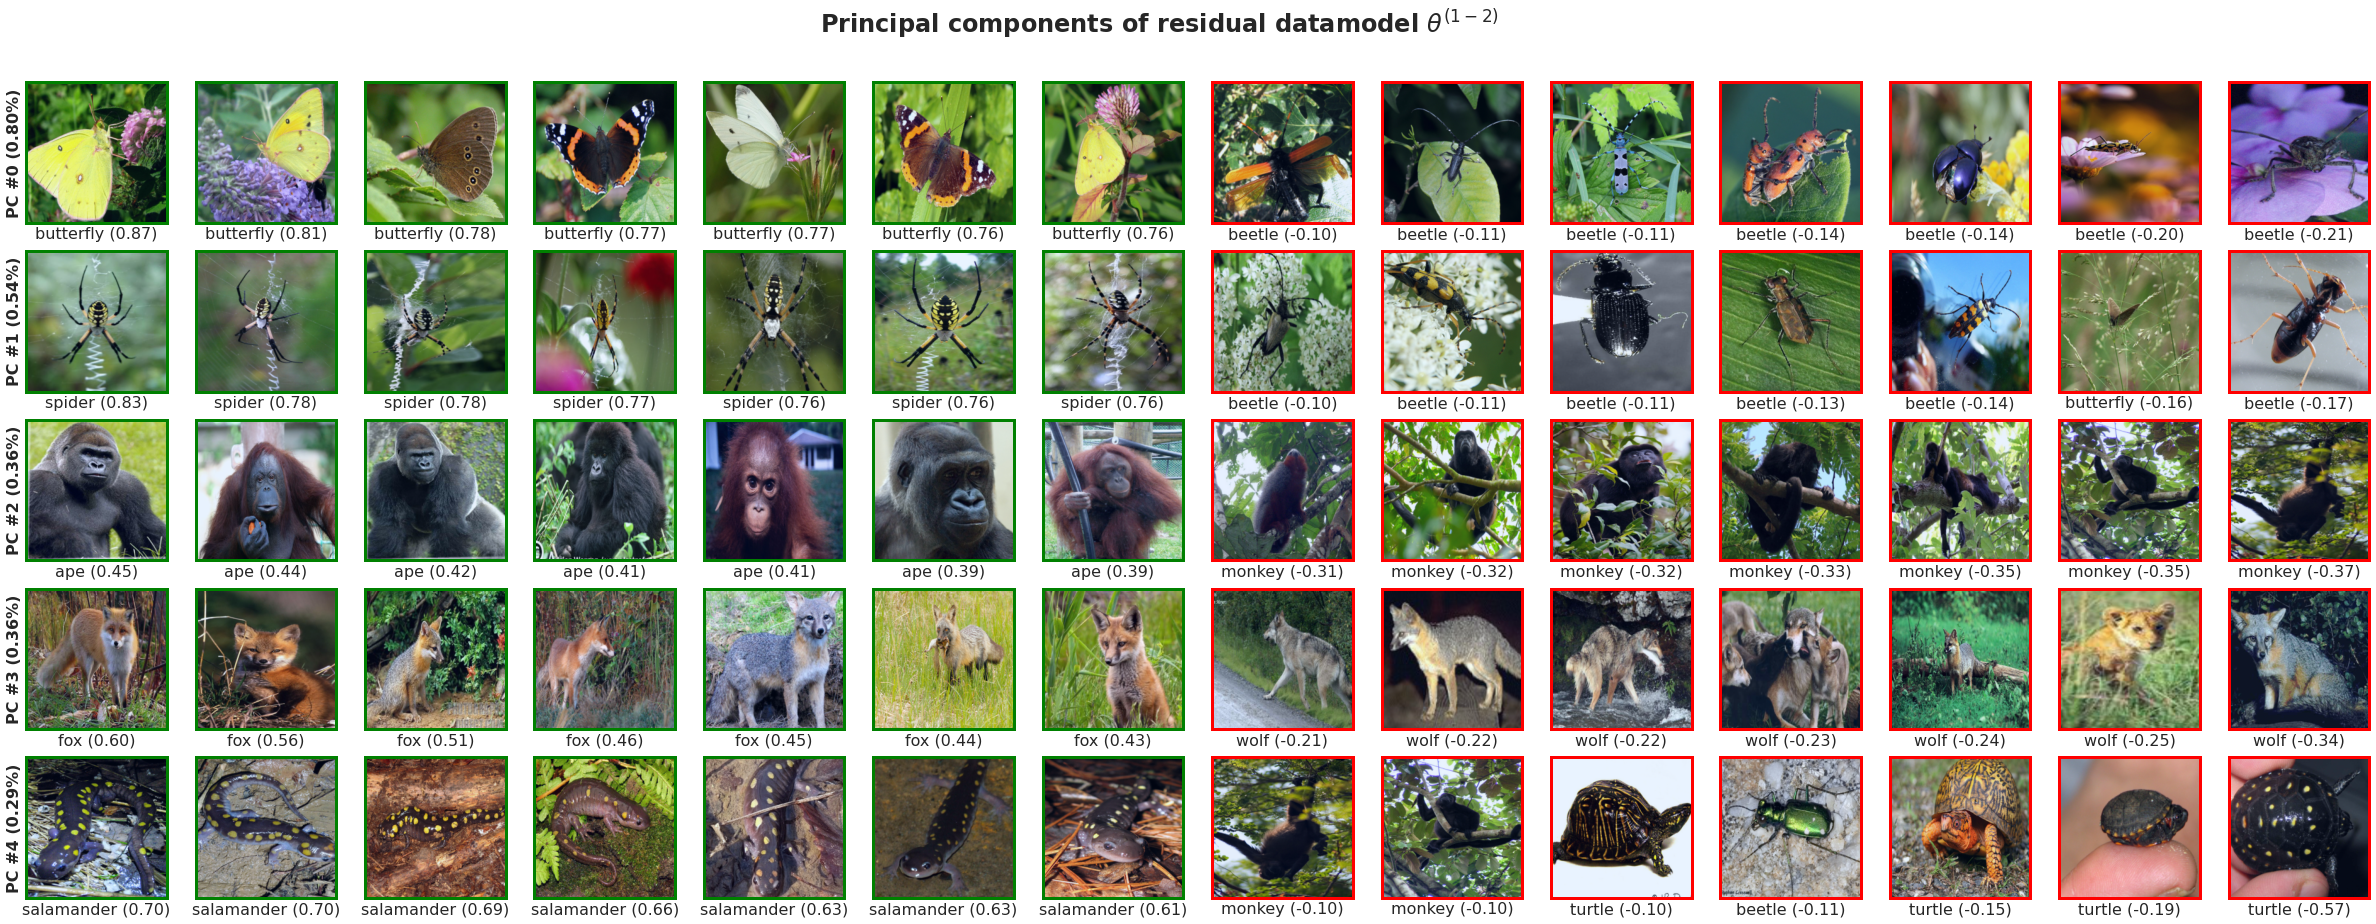

In [9]:
# compute + visualize PCA directions of residual datamodel (with-augmentation minus without-augmentation)
num_pcs = 50
_dsets = {'train': dsets['train'], 'test': dsets['val']}
pca = dm_utils.DatamodelResidualPCA(dm_paths['aug'], dm_paths['no_aug'], num_pcs, _dsets)
fig, ax_grid = pca.plot_principal_component_images(range(5), 7, class_names=class_names)
fig.suptitle(r'Principal components of residual datamodel $\theta^{(1-2)}$', fontsize=24, fontweight='bold', y=0.95)

## Explained variance of residual model PCs
PC components of residual datamodel matrix $\theta^{(1\setminus 2)}_x$ have high explained variance with respect to datamodel matrix $\theta^{(1)}$ (with augmentation) and low explained variance with respect to datamodel matrix $\theta^{(2)}$ (without augmentation).

<AxesSubplot:title={'center':'Comparison of explained variance fraction'}, xlabel='Explained variance under Algorithm $\\mathcal{A}_1$ (with augmentation)', ylabel='Explained variance under Algorithm $\\mathcal{A}_2$ (without augmentation)'>

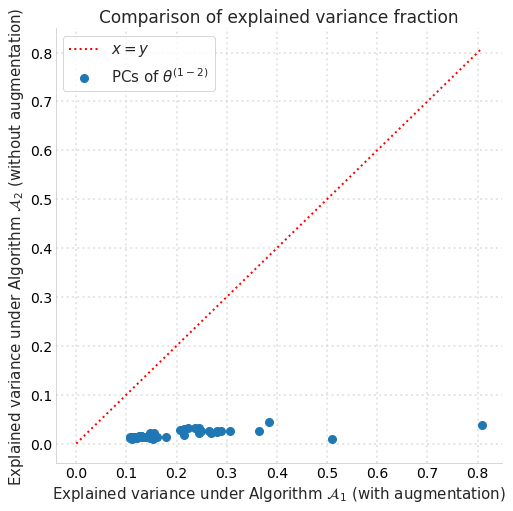

In [10]:
# visualize explained variance 
device = torch.device('cpu')
comps = torch.FloatTensor(pca.pca_components)
dm_map = {k: torch.FloatTensor(dm_utils.load_datamodel(v)) for k, v in dm_paths.items()}
ev_map = {k: dm_utils.get_explained_variance(dm, comps, device, batch_size=100)*100 for k, dm in dm_map.items()}

fig, ax = plt.subplots(1,1,figsize=(8,8))
xy = np.linspace(0, max(max(ev_map['aug']), max(ev_map['no_aug'])))
ax.plot(xy, xy, color='red', ls=':', lw=2, label=r'$x=y$')
ax.scatter(ev_map['aug'], ev_map['no_aug'], marker='o', s=64, label=r'PCs of $\theta^{(1-2)}$')
common_utils.update_ax(ax, 'Comparison of explained variance fraction', 
                       r'Explained variance under Algorithm $\mathcal{A}_1$ (with augmentation)',
                       r'Explained variance under Algorithm $\mathcal{A}_2$ (without augmentation)',
                       **font_kws)

## Subpopulations surfaced by PC directions #1 and #5
Visualize subpopulations of test examples surfaced by PC directions #1 and #5---the directions that we analyze in the paper. These test examples correspond to examples whose residual datamodel vectors $\theta^{(1-2)}_x$ are most (positively) aligned with the PC directions.

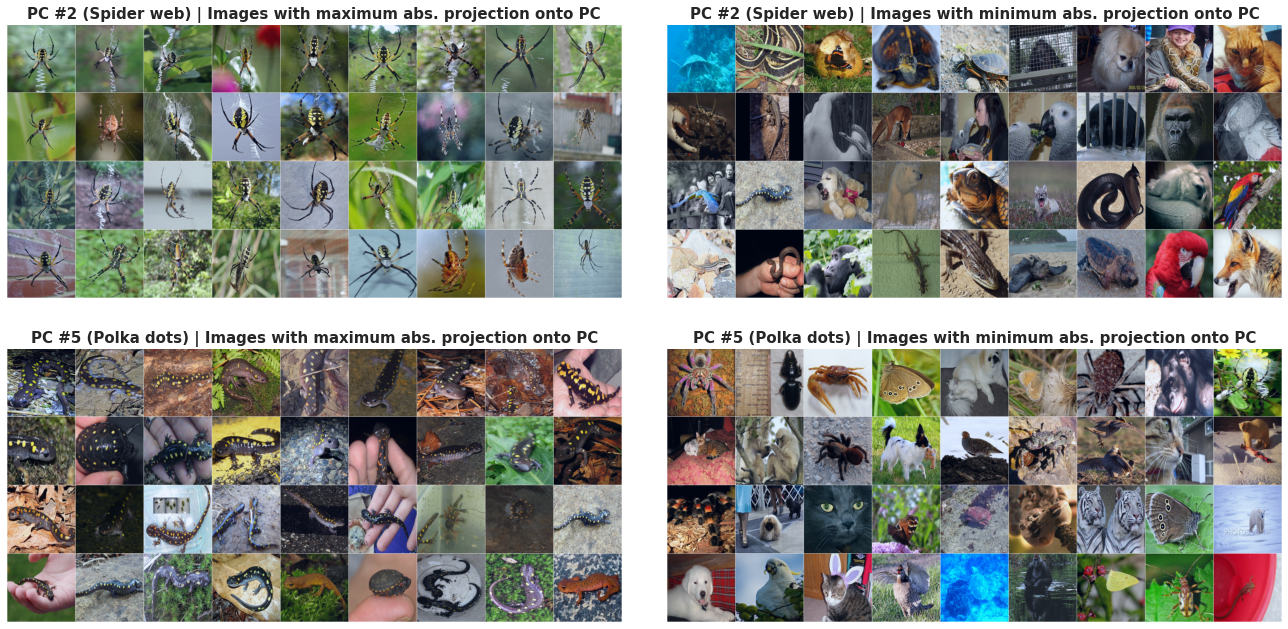

In [11]:
# visualize pca subpopulations of PC #2 (spider web) and PC#5 (polka dots)
comp_indices=[1,4]
num_comps = len(comp_indices)
num_imgs = 36
per_row = 9
title_fs = 15

fig, axs = plt.subplots(num_comps, 2, figsize=(18, 4.67*num_comps))
feat_names = ['Spider web', 'Polka dots']

for idx, ax_pair in enumerate(axs):
    direction = dm_utils.Direction(pca.pca_components[comp_indices[idx]], pca.X, pca.datasets_map['test'], use_abs=True)
    titles = ['PC #{} ({}) | Images with maximum abs. projection onto PC'.format(comp_indices[idx]+1, feat_names[idx]), 
              'PC #{} ({}) | Images with minimum abs. projection onto PC'.format(comp_indices[idx]+1, feat_names[idx])]
    direction.visualize_grid(num_imgs, per_row, titles=titles, axs=ax_pair, padding=1)

    for ax, title in zip(ax_pair, titles):
        ax.set_title(title, fontsize=title_fs, fontweight='bold')

fig.tight_layout()
fig.subplots_adjust(wspace=0.075)
None

## Effect of distinguishing feature transformations
Plot treatment effect of distinguishing feature transformations corresponding to "spider web" and "polka dots". See scripts in `counterfactuals/` for code. 

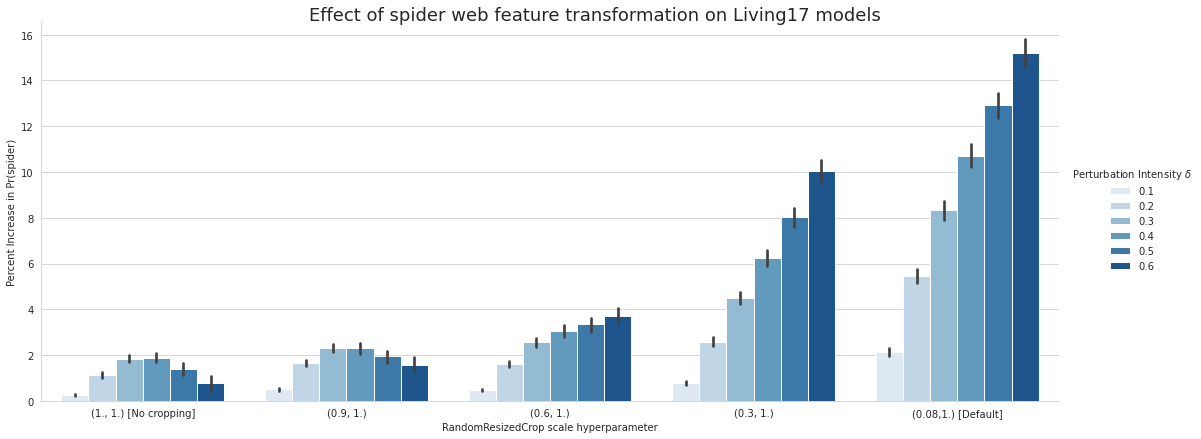

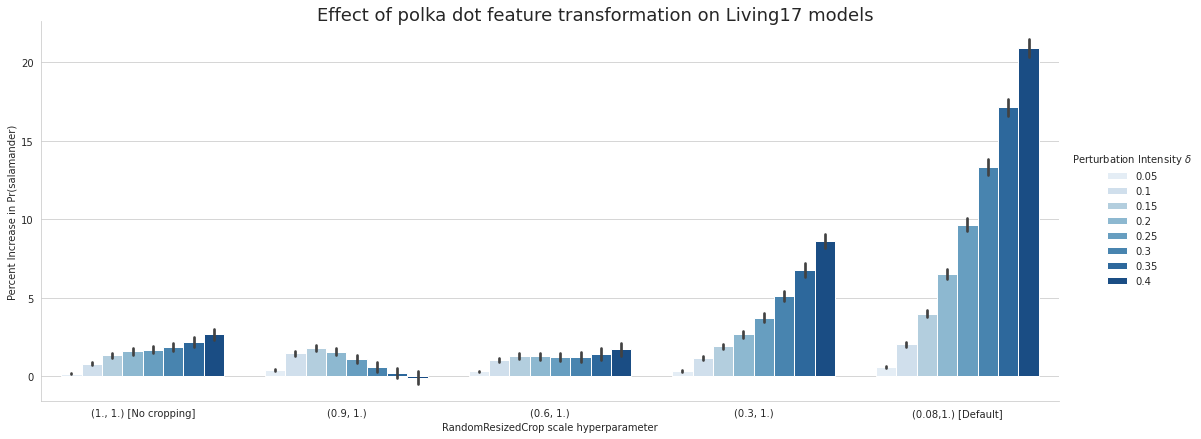

In [12]:
# plot counterfactual results 
def plot_salamander():
    df = pd.read_pickle('metadata/living17_salamander_dataframe.pkl')
    effect_col = '$\Pr(salamander|do(patch))-\Pr(salamander|control)$'
    new_effect_col = 'Percent Increase in Pr(salamander)'

    df['datamodel'] = df['datamodel'].apply(lambda d: {
        'No aug': '(1., 1.) [No cropping]',
        'Aug (0.9,1)': '(0.9, 1.)',
        'Aug (0.6,1)': '(0.6, 1.)',
        'Aug (0.3,1)': '(0.3, 1.)',
        'Aug (0.08,1)': '(0.08,1.) [Default]'
    }.get(d, d))

    df = df.sort_values('datamodel', ascending=False)

    df = df.rename(columns={'salamander-texture': 'Perturbation Intensity $\delta$', 
                            effect_col: new_effect_col,
                            'datamodel': 'RandomResizedCrop scale hyperparameter'})

    df[new_effect_col] *= 100

    fg = sns.catplot(y=new_effect_col, x='RandomResizedCrop scale hyperparameter',  palette='Blues',
                     hue='Perturbation Intensity $\delta$', kind='bar', data=df, aspect=2.5, height=6)

    fg.fig.suptitle(f'Effect of polka dot feature transformation on Living17 models', fontsize=18, y=1.01)
    return fg.fig

def plot_spider():
    df = pd.read_pickle('metadata/living17_spider_dataframe.pkl')
    effect_col = '$\Pr(spider|do(patch))-\Pr(spider|control)$'
    new_effect_col = 'Percent Increase in Pr(spider)'

    df['datamodel'] = df['datamodel'].apply(lambda d: {
        'No aug': '(1., 1.) [No cropping]',
        'Aug (0.9,1)': '(0.9, 1.)',
        'Aug (0.6,1)': '(0.6, 1.)',
        'Aug (0.3,1)': '(0.3, 1.)',
        'Aug (0.08,1)': '(0.08,1.) [Default]'
    }.get(d, d))

    df = df.sort_values('datamodel', ascending=False)

    df = df.rename(columns={'spider-web': 'Perturbation Intensity $\delta$', 
                            effect_col: new_effect_col,
                            'datamodel': 'RandomResizedCrop scale hyperparameter'})

    df[new_effect_col] *= 100

    fg = sns.catplot(y=new_effect_col, x='RandomResizedCrop scale hyperparameter',  palette='Blues',
                     hue='Perturbation Intensity $\delta$', kind='bar', data=df, aspect=2.5, height=6)

    fg.fig.suptitle(f'Effect of spider web feature transformation on Living17 models', fontsize=18, y=1.01)
    return fg.fig

plot_spider()
plot_salamander()
None